In [1]:
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Conv2D , MaxPool2D , Rescaling, Dropout 
from IPython.display import Image 
from random import randint
from tensorflow.keras.models import Sequential

StatementMeta(, , , SessionStarting, )

In [ ]:
#reimport baboon_hippo table and convert to pandas

df = spark.sql("SELECT * FROM DemoLakehouse.baboon_hippo")
animals_df=df.toPandas()

StatementMeta(, , , Waiting, )

In [ ]:
#generate the URL's for the lakehouse
animals_df['image_url'] = animals_df['filename'].apply(lambda filename: f"/lakehouse/default/Files/images/baboon_hippo/{filename}")
#add class labels
animals_df['label_enc'] = animals_df['label'].map({'hippopotamus': 0,
                                                    'baboon': 1})
animals_df=animals_df.sort_values(['filename'])


StatementMeta(, , , Waiting, )

In [ ]:
# nonexistant=[]
# for index, row in tqdm(animals_df.iterrows()):
#     image_url=row['image_url']
#     if not os.path.exists(image_url):
#         nonexistant.append(index)

StatementMeta(, , , Waiting, )

In [ ]:
#I'm cheating and know that these indices correspond to files that didn't download
#We should remove these rows for later
bad_indices=[139, 4260, 5138, 6243, 7234, 7200, 7269, 7304, 7309, 7407, 7433]
animals_df=animals_df.drop(bad_indices)

StatementMeta(, , , Waiting, )

In [ ]:
def display_random_image(df):
    rand_index=randint(0, df.shape[0])
    rand_row=df.loc[rand_index]
    animal=rand_row['label']
    image_url= rand_row['image_url']
    print(f"Animal in picture: {animal}")
    return Image(filename=image_url)


StatementMeta(, , , Waiting, )

In [ ]:
display_random_image(animals_df)

StatementMeta(, , , Waiting, )

In [ ]:
animals_df=animals_df.sample(frac=1, random_state=1031, ignore_index=True)

StatementMeta(, , , Waiting, )

In [ ]:
image_size = (224, 168)
batch_size = 32

StatementMeta(, , , Waiting, )

In [ ]:
#lets build a train-test split with 20% of samples reserved for testing.

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/lakehouse/default/Files/images/baboon_hippo",
    labels=list(animals_df['label_enc']),
    validation_split=0.2,
    subset="both",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
)

StatementMeta(, , , Waiting, )

In [ ]:
tensor_dim=image_size + (3,)
model = Sequential()
model.add(Rescaling(1.0 / 255, input_shape=tensor_dim))
model.add(Conv2D(3,16,padding="same", activation="relu"))
model.add(MaxPool2D())
# model.add(Conv2D(16,3,padding="same", activation="relu"))
# model.add(MaxPool2D())

model.add(Conv2D(3, 32, padding="same", activation="relu"))
model.add(MaxPool2D())


model.add(Conv2D(3, 64, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

StatementMeta(, , , Waiting, )

In [ ]:
model.summary()

StatementMeta(, , , Waiting, )

In [ ]:
animals_df['label'].value_counts()['hippopotamus'] / animals_df.shape[0]

StatementMeta(, , , Waiting, )

In [ ]:
#baseline accuracy
#4945

StatementMeta(, , , Waiting, )

In [ ]:
model.reset_states()
epochs = 100
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.001,
        patience=3,
        verbose=0,
        mode="auto",
        baseline=0.64,
        restore_best_weights=True,
        start_from_epoch=5,
    )
]
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history=model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds,
    )

StatementMeta(, , , Waiting, )

In [29]:
acc

StatementMeta(, 3ee7c730-89ce-4d94-b2fd-826d4345d08a, 39, Finished, Available)

[0.6377748847007751,
 0.6397153735160828,
 0.6397153735160828,
 0.6397153735160828]

StatementMeta(, 3ee7c730-89ce-4d94-b2fd-826d4345d08a, 40, Finished, Available)

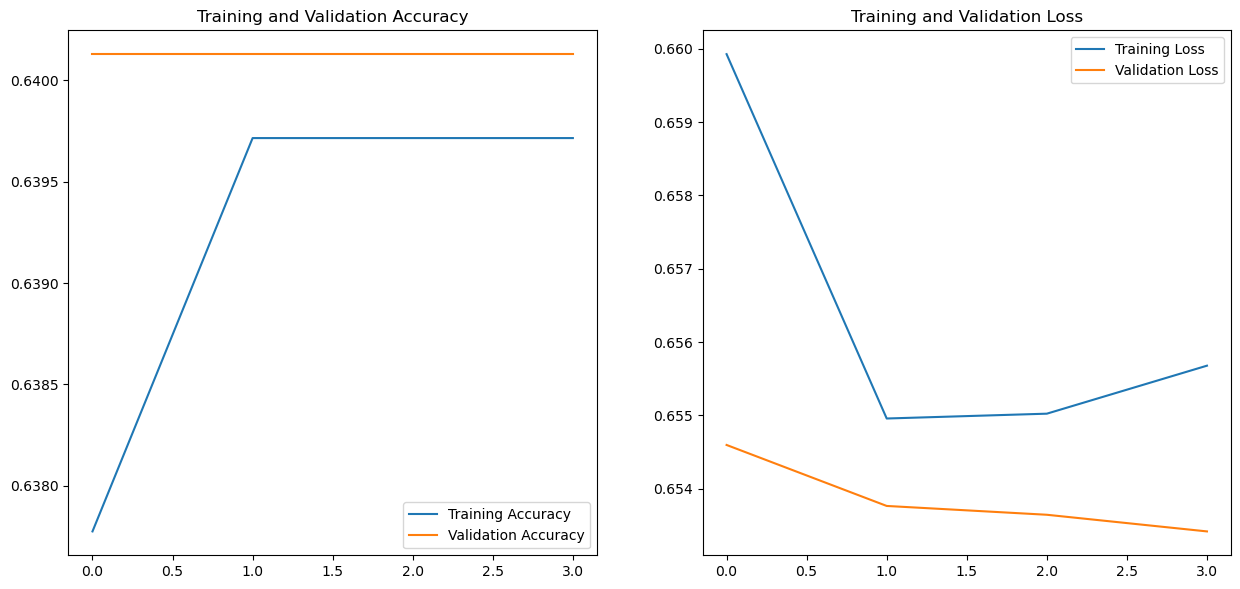

In [30]:
epochs_ran=4
epochs_range = range(epochs_ran)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

StatementMeta(, , , Cancelled, )